Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.


In [4]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [5]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


Prefetching data into GPU memory to optimize training process

In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

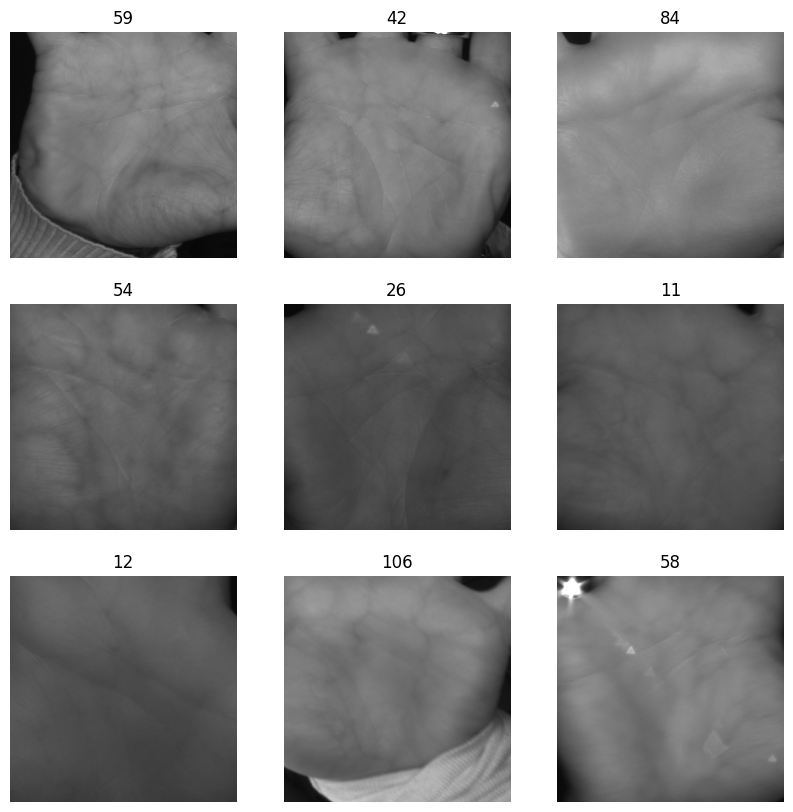

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

In [9]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

Define some key constants

In [10]:
num_classes = 110
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [11]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [13]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [14]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [15]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
43/44 [============================>.] - ETA: 0s - loss: 4.5960 - accuracy: 0.0247

  3%|▎         | 1/30 [00:21<10:35, 21.91s/it]

44/44 [==============================] - 22s 41ms/step - loss: 4.5873 - accuracy: 0.0249 - val_loss: 5.0359 - val_accuracy: 0.0045
Epoch 2/30
43/44 [============================>.] - ETA: 0s - loss: 4.0855 - accuracy: 0.0618

  7%|▋         | 2/30 [00:23<04:39,  9.98s/it]

44/44 [==============================] - 2s 33ms/step - loss: 4.0842 - accuracy: 0.0632 - val_loss: 4.9373 - val_accuracy: 0.0068
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 3.7331 - accuracy: 0.1158

 10%|█         | 3/30 [00:25<02:46,  6.15s/it]

44/44 [==============================] - 2s 33ms/step - loss: 3.7331 - accuracy: 0.1158 - val_loss: 4.3893 - val_accuracy: 0.0273
Epoch 4/30
43/44 [============================>.] - ETA: 0s - loss: 3.4359 - accuracy: 0.1533

 13%|█▎        | 4/30 [00:26<01:53,  4.37s/it]

44/44 [==============================] - 2s 34ms/step - loss: 3.4379 - accuracy: 0.1513 - val_loss: 3.7704 - val_accuracy: 0.0750
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 3.2133 - accuracy: 0.1896

 17%|█▋        | 5/30 [00:28<01:24,  3.39s/it]

44/44 [==============================] - 2s 33ms/step - loss: 3.2133 - accuracy: 0.1896 - val_loss: 3.4110 - val_accuracy: 0.1795
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 2.8735 - accuracy: 0.2521

 20%|██        | 6/30 [00:30<01:07,  2.80s/it]

44/44 [==============================] - 2s 34ms/step - loss: 2.8735 - accuracy: 0.2521 - val_loss: 3.0203 - val_accuracy: 0.2568
Epoch 7/30
43/44 [============================>.] - ETA: 0s - loss: 2.6051 - accuracy: 0.3132

 23%|██▎       | 7/30 [00:31<00:55,  2.43s/it]

44/44 [==============================] - 2s 35ms/step - loss: 2.6139 - accuracy: 0.3125 - val_loss: 2.9455 - val_accuracy: 0.2636
Epoch 8/30
43/44 [============================>.] - ETA: 0s - loss: 2.2327 - accuracy: 0.4150

 27%|██▋       | 8/30 [00:33<00:49,  2.23s/it]

44/44 [==============================] - 2s 36ms/step - loss: 2.2284 - accuracy: 0.4126 - val_loss: 2.7932 - val_accuracy: 0.2773
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 1.9306 - accuracy: 0.4879

 30%|███       | 9/30 [00:36<00:51,  2.43s/it]

44/44 [==============================] - 3s 49ms/step - loss: 1.9306 - accuracy: 0.4879 - val_loss: 3.1570 - val_accuracy: 0.2159
Epoch 10/30
43/44 [============================>.] - ETA: 0s - loss: 1.6724 - accuracy: 0.5392

 33%|███▎      | 10/30 [00:38<00:45,  2.28s/it]

44/44 [==============================] - 2s 40ms/step - loss: 1.6684 - accuracy: 0.5412 - val_loss: 3.3531 - val_accuracy: 0.1886
Epoch 11/30
43/44 [============================>.] - ETA: 0s - loss: 1.4755 - accuracy: 0.5894

 37%|███▋      | 11/30 [00:40<00:40,  2.12s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.4665 - accuracy: 0.5909 - val_loss: 3.6280 - val_accuracy: 0.1682
Epoch 12/30
43/44 [============================>.] - ETA: 0s - loss: 1.2000 - accuracy: 0.6751

 40%|████      | 12/30 [00:42<00:36,  2.05s/it]

44/44 [==============================] - 2s 39ms/step - loss: 1.2008 - accuracy: 0.6726 - val_loss: 2.2798 - val_accuracy: 0.4182
Epoch 13/30
43/44 [============================>.] - ETA: 0s - loss: 1.0729 - accuracy: 0.6969

 43%|████▎     | 13/30 [00:43<00:33,  1.98s/it]

44/44 [==============================] - 2s 36ms/step - loss: 1.0719 - accuracy: 0.6974 - val_loss: 1.5599 - val_accuracy: 0.6250
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7749

 47%|████▋     | 14/30 [00:45<00:30,  1.88s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.8251 - accuracy: 0.7749 - val_loss: 1.5434 - val_accuracy: 0.6091
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.8274

 50%|█████     | 15/30 [00:47<00:27,  1.81s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.6309 - accuracy: 0.8274 - val_loss: 1.9025 - val_accuracy: 0.5227
Epoch 16/30
43/44 [============================>.] - ETA: 0s - loss: 0.5025 - accuracy: 0.8561

 53%|█████▎    | 16/30 [00:48<00:24,  1.77s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.5089 - accuracy: 0.8537 - val_loss: 2.1752 - val_accuracy: 0.5068
Epoch 17/30
43/44 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8714

 57%|█████▋    | 17/30 [00:50<00:22,  1.73s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.4625 - accuracy: 0.8714 - val_loss: 1.0075 - val_accuracy: 0.7932
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8956

 60%|██████    | 18/30 [00:52<00:20,  1.70s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.3692 - accuracy: 0.8956 - val_loss: 1.2741 - val_accuracy: 0.6864
Epoch 19/30
43/44 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.9012

 63%|██████▎   | 19/30 [00:53<00:18,  1.69s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.3340 - accuracy: 0.9006 - val_loss: 0.8935 - val_accuracy: 0.7932
Epoch 20/30
43/44 [============================>.] - ETA: 0s - loss: 0.2731 - accuracy: 0.9186

 67%|██████▋   | 20/30 [00:55<00:16,  1.68s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.2736 - accuracy: 0.9183 - val_loss: 0.8277 - val_accuracy: 0.8227
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9389

 70%|███████   | 21/30 [00:57<00:14,  1.66s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.2251 - accuracy: 0.9389 - val_loss: 0.6468 - val_accuracy: 0.8636
Epoch 22/30
43/44 [============================>.] - ETA: 0s - loss: 0.1953 - accuracy: 0.9491

 73%|███████▎  | 22/30 [00:58<00:13,  1.65s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.1981 - accuracy: 0.9489 - val_loss: 0.7144 - val_accuracy: 0.8500
Epoch 23/30
43/44 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9637

 77%|███████▋  | 23/30 [01:00<00:11,  1.65s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.1352 - accuracy: 0.9638 - val_loss: 0.6946 - val_accuracy: 0.8409
Epoch 24/30
43/44 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9637

 80%|████████  | 24/30 [01:01<00:09,  1.64s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.1286 - accuracy: 0.9638 - val_loss: 0.9704 - val_accuracy: 0.7773
Epoch 25/30
43/44 [============================>.] - ETA: 0s - loss: 0.1338 - accuracy: 0.9658

 83%|████████▎ | 25/30 [01:03<00:08,  1.66s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1325 - accuracy: 0.9666 - val_loss: 0.5714 - val_accuracy: 0.8841
Epoch 26/30
42/44 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9650

 87%|████████▋ | 26/30 [01:05<00:06,  1.69s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.1241 - accuracy: 0.9638 - val_loss: 0.9844 - val_accuracy: 0.7545
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9773

 90%|█████████ | 27/30 [01:07<00:05,  1.72s/it]

44/44 [==============================] - 2s 37ms/step - loss: 0.0857 - accuracy: 0.9773 - val_loss: 0.5990 - val_accuracy: 0.8841
Epoch 28/30
42/44 [===========================>..] - ETA: 0s - loss: 0.0947 - accuracy: 0.9777

 93%|█████████▎| 28/30 [01:08<00:03,  1.69s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.0962 - accuracy: 0.9766 - val_loss: 0.5209 - val_accuracy: 0.9045
Epoch 29/30
43/44 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9898

 97%|█████████▋| 29/30 [01:10<00:01,  1.67s/it]

44/44 [==============================] - 2s 34ms/step - loss: 0.0601 - accuracy: 0.9886 - val_loss: 0.5119 - val_accuracy: 0.9068
Epoch 30/30
43/44 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9811

100%|██████████| 30/30 [01:12<00:00,  1.71s/it]

44/44 [==============================] - 2s 37ms/step - loss: 0.0733 - accuracy: 0.9808 - val_loss: 0.7724 - val_accuracy: 0.8455


100%|██████████| 30/30 [01:12<00:00,  2.41s/it]


Finished training AlexNet in 72.20s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 4.6857 - accuracy: 0.0114

  3%|▎         | 1/30 [00:14<06:59, 14.46s/it]

44/44 [==============================] - 14s 221ms/step - loss: 4.6857 - accuracy: 0.0114 - val_loss: 7.0693 - val_accuracy: 0.0068
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.4748 - accuracy: 0.0206

  7%|▋         | 2/30 [00:22<05:02, 10.82s/it]

44/44 [==============================] - 8s 185ms/step - loss: 4.4748 - accuracy: 0.0206 - val_loss: 5.5107 - val_accuracy: 0.0114
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 4.0979 - accuracy: 0.0653

 10%|█         | 3/30 [00:30<04:19,  9.62s/it]

44/44 [==============================] - 8s 183ms/step - loss: 4.0979 - accuracy: 0.0653 - val_loss: 4.8964 - val_accuracy: 0.0045
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 3.7393 - accuracy: 0.0774

 13%|█▎        | 4/30 [00:39<03:56,  9.09s/it]

44/44 [==============================] - 8s 185ms/step - loss: 3.7393 - accuracy: 0.0774 - val_loss: 7.8301 - val_accuracy: 0.0159
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 3.5661 - accuracy: 0.1250

 17%|█▋        | 5/30 [00:47<03:39,  8.79s/it]

44/44 [==============================] - 8s 185ms/step - loss: 3.5661 - accuracy: 0.1250 - val_loss: 3.8577 - val_accuracy: 0.0659
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 3.3406 - accuracy: 0.1619

 20%|██        | 6/30 [00:55<03:25,  8.58s/it]

44/44 [==============================] - 8s 183ms/step - loss: 3.3406 - accuracy: 0.1619 - val_loss: 3.3629 - val_accuracy: 0.1591
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 3.0024 - accuracy: 0.2294

 23%|██▎       | 7/30 [01:03<03:14,  8.47s/it]

44/44 [==============================] - 8s 184ms/step - loss: 3.0024 - accuracy: 0.2294 - val_loss: 2.9424 - val_accuracy: 0.2886
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 2.5232 - accuracy: 0.3409

 27%|██▋       | 8/30 [01:12<03:06,  8.46s/it]

44/44 [==============================] - 8s 188ms/step - loss: 2.5232 - accuracy: 0.3409 - val_loss: 2.7715 - val_accuracy: 0.3136
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 2.0954 - accuracy: 0.4425

 30%|███       | 9/30 [01:20<02:56,  8.42s/it]

44/44 [==============================] - 8s 186ms/step - loss: 2.0954 - accuracy: 0.4425 - val_loss: 2.0743 - val_accuracy: 0.4955
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 1.6478 - accuracy: 0.5753

 33%|███▎      | 10/30 [01:29<02:48,  8.41s/it]

44/44 [==============================] - 8s 187ms/step - loss: 1.6478 - accuracy: 0.5753 - val_loss: 1.6310 - val_accuracy: 0.6386
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 1.2852 - accuracy: 0.6648

 37%|███▋      | 11/30 [01:37<02:39,  8.38s/it]

44/44 [==============================] - 8s 186ms/step - loss: 1.2852 - accuracy: 0.6648 - val_loss: 1.5352 - val_accuracy: 0.6068
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 1.1729 - accuracy: 0.6939

 40%|████      | 12/30 [01:45<02:30,  8.34s/it]

44/44 [==============================] - 8s 184ms/step - loss: 1.1729 - accuracy: 0.6939 - val_loss: 1.2824 - val_accuracy: 0.7045
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.7472

 43%|████▎     | 13/30 [01:53<02:21,  8.30s/it]

44/44 [==============================] - 8s 184ms/step - loss: 0.9302 - accuracy: 0.7472 - val_loss: 1.4131 - val_accuracy: 0.6932
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.7611 - accuracy: 0.7962

 47%|████▋     | 14/30 [02:02<02:12,  8.30s/it]

44/44 [==============================] - 8s 185ms/step - loss: 0.7611 - accuracy: 0.7962 - val_loss: 0.9829 - val_accuracy: 0.7864
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.8359

 50%|█████     | 15/30 [02:10<02:04,  8.27s/it]

44/44 [==============================] - 8s 183ms/step - loss: 0.5765 - accuracy: 0.8359 - val_loss: 1.2014 - val_accuracy: 0.7068
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.8693

 53%|█████▎    | 16/30 [02:18<01:55,  8.25s/it]

44/44 [==============================] - 8s 183ms/step - loss: 0.4810 - accuracy: 0.8693 - val_loss: 0.8986 - val_accuracy: 0.8250
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.9126

 57%|█████▋    | 17/30 [02:26<01:47,  8.25s/it]

44/44 [==============================] - 8s 185ms/step - loss: 0.3481 - accuracy: 0.9126 - val_loss: 1.0261 - val_accuracy: 0.8364
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.9084

 60%|██████    | 18/30 [02:35<01:39,  8.30s/it]

44/44 [==============================] - 8s 188ms/step - loss: 0.3497 - accuracy: 0.9084 - val_loss: 0.7566 - val_accuracy: 0.8795
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9510

 63%|██████▎   | 19/30 [02:43<01:31,  8.32s/it]

44/44 [==============================] - 8s 187ms/step - loss: 0.1762 - accuracy: 0.9510 - val_loss: 1.0006 - val_accuracy: 0.8682
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9560

 67%|██████▋   | 20/30 [02:51<01:23,  8.32s/it]

44/44 [==============================] - 8s 186ms/step - loss: 0.2005 - accuracy: 0.9560 - val_loss: 0.7451 - val_accuracy: 0.9000
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9737

 70%|███████   | 21/30 [03:00<01:14,  8.31s/it]

44/44 [==============================] - 8s 184ms/step - loss: 0.1387 - accuracy: 0.9737 - val_loss: 0.8232 - val_accuracy: 0.8864
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9766

 73%|███████▎  | 22/30 [03:08<01:06,  8.28s/it]

44/44 [==============================] - 8s 184ms/step - loss: 0.0931 - accuracy: 0.9766 - val_loss: 0.6788 - val_accuracy: 0.9068
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9830

 77%|███████▋  | 23/30 [03:16<00:57,  8.27s/it]

44/44 [==============================] - 8s 184ms/step - loss: 0.0557 - accuracy: 0.9830 - val_loss: 0.7183 - val_accuracy: 0.9068
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9794

 80%|████████  | 24/30 [03:24<00:49,  8.26s/it]

44/44 [==============================] - 8s 185ms/step - loss: 0.0916 - accuracy: 0.9794 - val_loss: 1.0723 - val_accuracy: 0.9023
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9652

 83%|████████▎ | 25/30 [03:33<00:41,  8.30s/it]

44/44 [==============================] - 8s 187ms/step - loss: 0.1263 - accuracy: 0.9652 - val_loss: 0.5694 - val_accuracy: 0.9023
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9822

 87%|████████▋ | 26/30 [03:41<00:33,  8.29s/it]

44/44 [==============================] - 8s 185ms/step - loss: 0.0576 - accuracy: 0.9822 - val_loss: 0.4859 - val_accuracy: 0.9295
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9936

 90%|█████████ | 27/30 [03:49<00:24,  8.31s/it]

44/44 [==============================] - 8s 187ms/step - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.6391 - val_accuracy: 0.9250
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9929

 93%|█████████▎| 28/30 [03:58<00:16,  8.36s/it]

44/44 [==============================] - 8s 189ms/step - loss: 0.0271 - accuracy: 0.9929 - val_loss: 0.7698 - val_accuracy: 0.8864
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9922

 97%|█████████▋| 29/30 [04:06<00:08,  8.37s/it]

44/44 [==============================] - 8s 187ms/step - loss: 0.0280 - accuracy: 0.9922 - val_loss: 0.4765 - val_accuracy: 0.9295
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9929

100%|██████████| 30/30 [04:15<00:00,  8.42s/it]

44/44 [==============================] - 9s 190ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.7172 - val_accuracy: 0.9136


100%|██████████| 30/30 [04:15<00:00,  8.51s/it]


Finished training VGG16 in 255.26s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 4.7032 - accuracy: 0.0057

  3%|▎         | 1/30 [00:10<05:02, 10.44s/it]

44/44 [==============================] - 10s 212ms/step - loss: 4.7032 - accuracy: 0.0057 - val_loss: 4.7012 - val_accuracy: 0.0023
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 4.6967 - accuracy: 0.0092

  7%|▋         | 2/30 [00:19<04:29,  9.62s/it]

44/44 [==============================] - 9s 203ms/step - loss: 4.6967 - accuracy: 0.0092 - val_loss: 4.7008 - val_accuracy: 0.0045
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 4.6635 - accuracy: 0.0121

 10%|█         | 3/30 [00:28<04:11,  9.30s/it]

44/44 [==============================] - 9s 199ms/step - loss: 4.6635 - accuracy: 0.0121 - val_loss: 4.6596 - val_accuracy: 0.0000e+00
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 4.5435 - accuracy: 0.0220

 13%|█▎        | 4/30 [00:37<03:57,  9.14s/it]

44/44 [==============================] - 9s 199ms/step - loss: 4.5435 - accuracy: 0.0220 - val_loss: 4.5268 - val_accuracy: 0.0250
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 4.3404 - accuracy: 0.0483

 17%|█▋        | 5/30 [00:46<03:46,  9.06s/it]

44/44 [==============================] - 9s 199ms/step - loss: 4.3404 - accuracy: 0.0483 - val_loss: 4.3566 - val_accuracy: 0.0477
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 4.0494 - accuracy: 0.0980

 20%|██        | 6/30 [00:55<03:37,  9.08s/it]

44/44 [==============================] - 9s 204ms/step - loss: 4.0494 - accuracy: 0.0980 - val_loss: 4.0925 - val_accuracy: 0.0909
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 3.6530 - accuracy: 0.1335

 23%|██▎       | 7/30 [01:04<03:30,  9.14s/it]

44/44 [==============================] - 9s 207ms/step - loss: 3.6530 - accuracy: 0.1335 - val_loss: 3.6980 - val_accuracy: 0.1250
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 3.2110 - accuracy: 0.2060

 27%|██▋       | 8/30 [01:13<03:22,  9.19s/it]

44/44 [==============================] - 9s 207ms/step - loss: 3.2110 - accuracy: 0.2060 - val_loss: 3.4912 - val_accuracy: 0.1886
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 2.9283 - accuracy: 0.2649

 30%|███       | 9/30 [01:23<03:13,  9.22s/it]

44/44 [==============================] - 9s 208ms/step - loss: 2.9283 - accuracy: 0.2649 - val_loss: 3.1730 - val_accuracy: 0.2341
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 2.5567 - accuracy: 0.3366

 33%|███▎      | 10/30 [01:32<03:04,  9.22s/it]

44/44 [==============================] - 9s 206ms/step - loss: 2.5567 - accuracy: 0.3366 - val_loss: 2.9420 - val_accuracy: 0.2864
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 2.2833 - accuracy: 0.4077

 37%|███▋      | 11/30 [01:41<02:55,  9.24s/it]

44/44 [==============================] - 9s 207ms/step - loss: 2.2833 - accuracy: 0.4077 - val_loss: 2.6019 - val_accuracy: 0.3886
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 1.9225 - accuracy: 0.4851

 40%|████      | 12/30 [01:50<02:45,  9.20s/it]

44/44 [==============================] - 9s 202ms/step - loss: 1.9225 - accuracy: 0.4851 - val_loss: 2.5969 - val_accuracy: 0.4364
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 1.5915 - accuracy: 0.5611

 43%|████▎     | 13/30 [01:59<02:35,  9.13s/it]

44/44 [==============================] - 9s 201ms/step - loss: 1.5915 - accuracy: 0.5611 - val_loss: 2.4246 - val_accuracy: 0.4659
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 1.3350 - accuracy: 0.6555

 47%|████▋     | 14/30 [02:08<02:25,  9.12s/it]

44/44 [==============================] - 9s 203ms/step - loss: 1.3350 - accuracy: 0.6555 - val_loss: 2.3757 - val_accuracy: 0.5614
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 1.0935 - accuracy: 0.6918

 50%|█████     | 15/30 [02:17<02:15,  9.06s/it]

44/44 [==============================] - 9s 199ms/step - loss: 1.0935 - accuracy: 0.6918 - val_loss: 2.0731 - val_accuracy: 0.6364
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 1.0013 - accuracy: 0.7266

 53%|█████▎    | 16/30 [02:26<02:06,  9.05s/it]

44/44 [==============================] - 9s 202ms/step - loss: 1.0013 - accuracy: 0.7266 - val_loss: 1.8994 - val_accuracy: 0.6750
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.7933

 57%|█████▋    | 17/30 [02:35<01:58,  9.09s/it]

44/44 [==============================] - 9s 205ms/step - loss: 0.7400 - accuracy: 0.7933 - val_loss: 1.7183 - val_accuracy: 0.7114
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.8558

 60%|██████    | 18/30 [02:45<01:49,  9.09s/it]

44/44 [==============================] - 9s 203ms/step - loss: 0.5262 - accuracy: 0.8558 - val_loss: 2.2274 - val_accuracy: 0.7386
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.8842

 63%|██████▎   | 19/30 [02:54<01:39,  9.08s/it]

44/44 [==============================] - 9s 202ms/step - loss: 0.4784 - accuracy: 0.8842 - val_loss: 1.9201 - val_accuracy: 0.7591
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.9084

 67%|██████▋   | 20/30 [03:03<01:30,  9.07s/it]

44/44 [==============================] - 9s 202ms/step - loss: 0.3293 - accuracy: 0.9084 - val_loss: 1.5782 - val_accuracy: 0.7659
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9446

 70%|███████   | 21/30 [03:12<01:21,  9.05s/it]

44/44 [==============================] - 9s 202ms/step - loss: 0.2348 - accuracy: 0.9446 - val_loss: 1.9364 - val_accuracy: 0.8227
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9567

 73%|███████▎  | 22/30 [03:21<01:12,  9.04s/it]

44/44 [==============================] - 9s 202ms/step - loss: 0.1837 - accuracy: 0.9567 - val_loss: 1.9291 - val_accuracy: 0.8227
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9581

 77%|███████▋  | 23/30 [03:30<01:03,  9.08s/it]

44/44 [==============================] - 9s 204ms/step - loss: 0.1711 - accuracy: 0.9581 - val_loss: 1.6936 - val_accuracy: 0.8295
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9716

 80%|████████  | 24/30 [03:39<00:54,  9.08s/it]

44/44 [==============================] - 9s 202ms/step - loss: 0.1133 - accuracy: 0.9716 - val_loss: 2.4062 - val_accuracy: 0.8273
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9688

 83%|████████▎ | 25/30 [03:48<00:45,  9.14s/it]

44/44 [==============================] - 9s 208ms/step - loss: 0.1307 - accuracy: 0.9688 - val_loss: 1.6862 - val_accuracy: 0.8523
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9645

 87%|████████▋ | 26/30 [03:58<00:36,  9.18s/it]

44/44 [==============================] - 9s 204ms/step - loss: 0.1270 - accuracy: 0.9645 - val_loss: 1.8504 - val_accuracy: 0.8386
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9780

 90%|█████████ | 27/30 [04:07<00:27,  9.13s/it]

44/44 [==============================] - 9s 201ms/step - loss: 0.1003 - accuracy: 0.9780 - val_loss: 1.7431 - val_accuracy: 0.8477
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9830

 93%|█████████▎| 28/30 [04:15<00:18,  9.08s/it]

44/44 [==============================] - 9s 200ms/step - loss: 0.0706 - accuracy: 0.9830 - val_loss: 2.2131 - val_accuracy: 0.8273
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9787

 97%|█████████▋| 29/30 [04:24<00:09,  9.01s/it]

44/44 [==============================] - 9s 198ms/step - loss: 0.0955 - accuracy: 0.9787 - val_loss: 1.7175 - val_accuracy: 0.8341
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9844

100%|██████████| 30/30 [04:33<00:00,  8.96s/it]

44/44 [==============================] - 9s 198ms/step - loss: 0.0518 - accuracy: 0.9844 - val_loss: 1.9663 - val_accuracy: 0.8568


100%|██████████| 30/30 [04:33<00:00,  9.12s/it]

Finished training VGG19 in 273.68s



Defining function to plot model performance

In [16]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

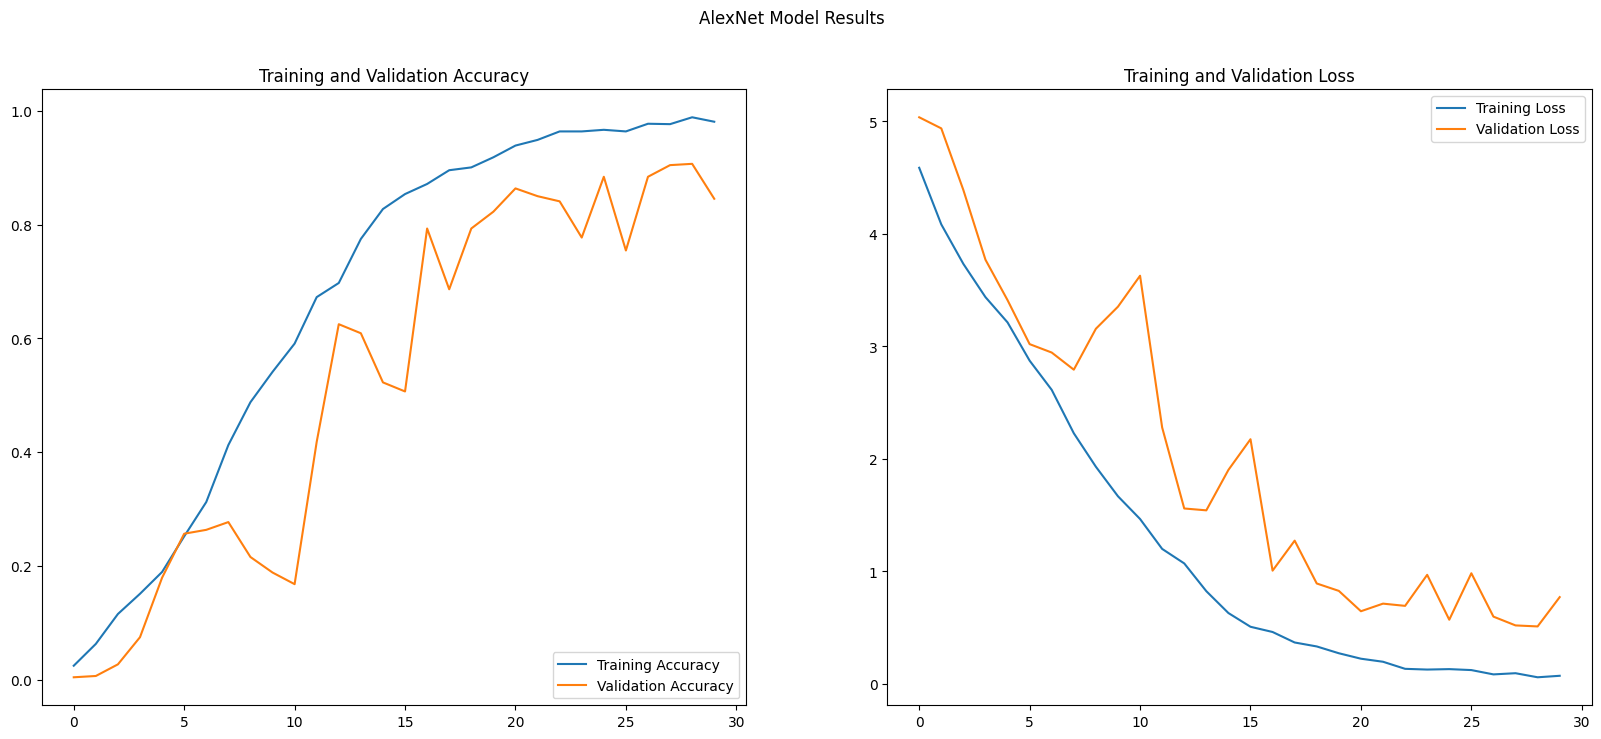

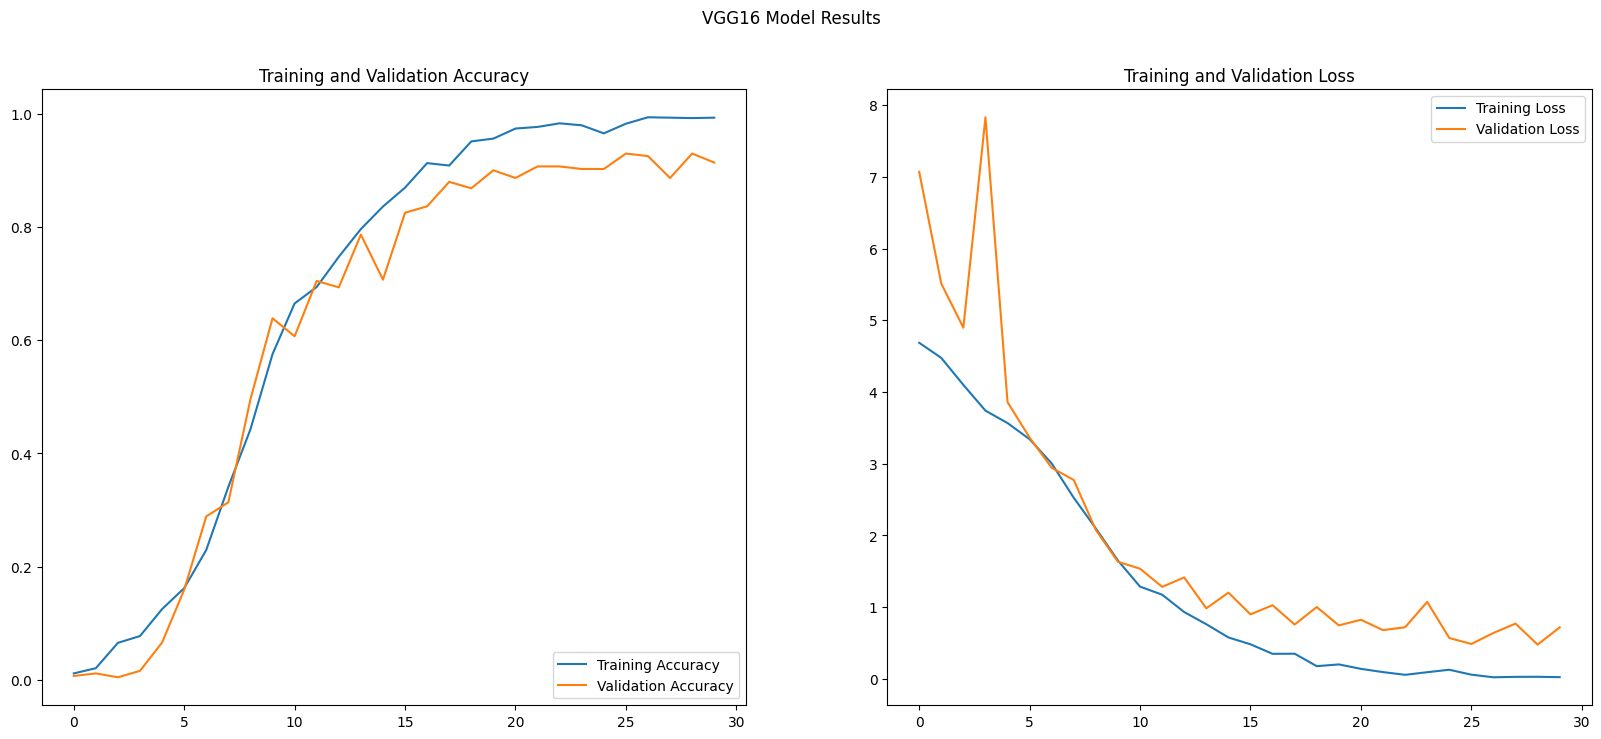

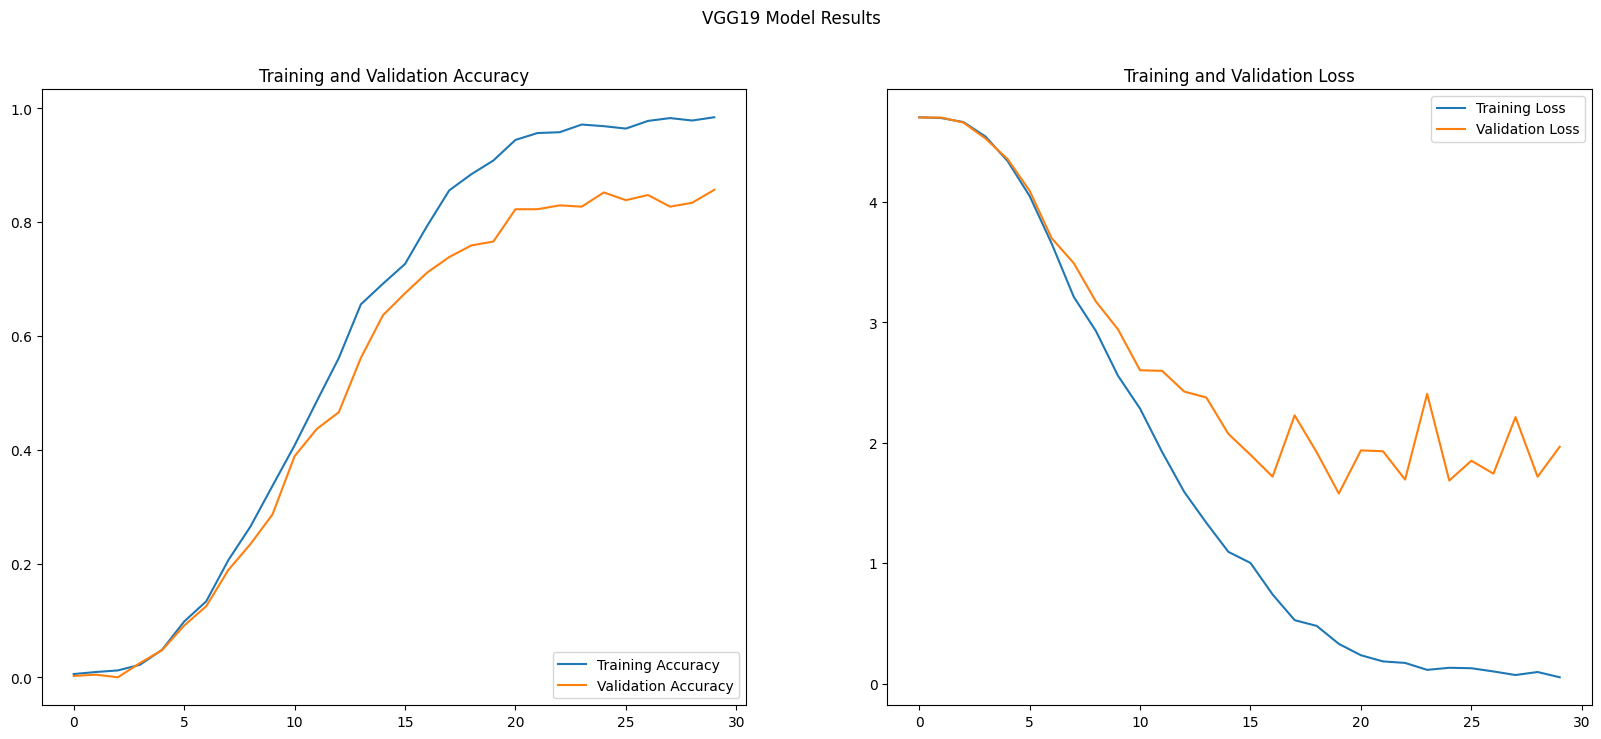

In [17]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

In [21]:
for name, model in models.items():
    test_loss, test_accuracy = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print()

11/11 [==============================] - 1s 20ms/step - loss: 0.2875 - accuracy: 0.9290
AlexNet Model Results:
Test accuracy: 92.90%
Test loss: 0.2875

11/11 [==============================] - 1s 47ms/step - loss: 0.2012 - accuracy: 0.9886
VGG16 Model Results:
Test accuracy: 98.86%
Test loss: 0.2012

11/11 [==============================] - 1s 49ms/step - loss: 0.5199 - accuracy: 0.9545
VGG19 Model Results:
Test accuracy: 95.45%
Test loss: 0.5199



Saving models and their training histories

In [19]:
for name, model in models.items():
    model.save(f'Saved Models/VERA/{name}-30-Epochs.keras')
    print(f'Saved {name} Model')

for name, model in model_histories.items():
    with open(f'Model Histories/VERA/{name}.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model
Saved VGG16 Model
Saved VGG19 Model


In [20]:
# img = keras.utils.load_img(
#     "Full Data/roi/001-M/01/001_L_1_1.png", target_size=image_size
# )
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# predicted_class_index = tf.argmax(predictions[0]).numpy()
# print('Predicted Class:', predicted_class_index)